# ЯПдляИИ
### Пиняева Анна Андреевна
### НПИмд-01-24
### 1132249572

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

2024-11-28 15:18:15.771173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_to_annotations = '/Users/anna/Downloads/CLEVR_v1.0/scenes/CLEVR_train_scenes.json'
with open(path_to_annotations, 'r') as f:
    clevr_data = json.load(f)

scenes = clevr_data['scenes']

In [3]:
path_to_questions = '/Users/anna/Downloads/CLEVR_v1.0/questions/CLEVR_train_questions.json'
with open(path_to_questions, 'r') as f:
    clevr_questions = json.load(f)
    
questions = clevr_questions['questions']



In [4]:
# Проверим структуру одного объекта в сцене
sample_scene = scenes[0]  # Выбираем первую сцену для примера
print(sample_scene['objects'][0])  # Выводим первый объект в этой сцене

{'color': 'blue', 'size': 'large', 'rotation': 269.8517172617167, 'shape': 'cube', '3d_coords': [-1.3705521821975708, 2.0794010162353516, 0.699999988079071], 'material': 'rubber', 'pixel_coords': [269, 88, 12.661545753479004]}


In [5]:
print(questions[0])  

{'image_index': 0, 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []}, {'inputs': [0], 'function': 'filter_size', 'value_inputs': ['large']}, {'inputs': [1], 'function': 'filter_color', 'value_inputs': ['green']}, {'inputs': [2], 'function': 'count', 'value_inputs': []}, {'inputs': [], 'function': 'scene', 'value_inputs': []}, {'inputs': [4], 'function': 'filter_size', 'value_inputs': ['large']}, {'inputs': [5], 'function': 'filter_color', 'value_inputs': ['purple']}, {'inputs': [6], 'function': 'filter_material', 'value_inputs': ['metal']}, {'inputs': [7], 'function': 'filter_shape', 'value_inputs': ['cube']}, {'inputs': [8], 'function': 'count', 'value_inputs': []}, {'inputs': [3, 9], 'function': 'greater_than', 'value_inputs': []}], 'question_index': 0, 'image_filename': 'CLEVR_train_000000.png', 'question_family_index': 2, 'split': 'train', 'answer': 'yes', 'question': 'Are there more big green things than large purple shiny cubes?'}


In [6]:
# 1. Предобработка данных
def normalize_coordinates(data):
    coords = np.array([obj for pair in data for obj in pair])
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    norm_data = (data - min_coords) / (max_coords - min_coords)
    return norm_data

def balance_classes(labels):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = dict(enumerate(class_weights))
    return class_weights_dict

In [7]:
# Создание данных для задачи
def create_relational_data_from_scenes(scenes):
    object_pairs, labels = [], []
    for scene in scenes:
        objects = scene['objects']
        for i in range(len(objects)):
            for j in range(i + 1, len(objects)):
                obj1 = np.array(objects[i]['3d_coords'])
                obj2 = np.array(objects[j]['3d_coords'])
                label = 1 if obj1[0] < obj2[0] else 0
                object_pairs.append([obj1, obj2])
                labels.append(label)
    return np.array(object_pairs), np.array(labels)


In [8]:
# Загрузка данных
object_pairs, labels = create_relational_data_from_scenes(scenes)

# Нормализация координат
object_pairs = normalize_coordinates(object_pairs)


In [9]:
# 3. Загрузка вопросов и соответствие сценам
def parse_questions_and_answers(questions, scenes):
    object_pairs, text_questions, labels = [], [], []
    for q in questions:
        image_idx = q['image_index']
        question_text = q['question']
        answer = 1 if q['answer'] == 'yes' else 0

        # Получаем сцену по индексу
        scene = scenes[image_idx]
        objects = scene['objects']

        for i in range(len(objects)):
            for j in range(i + 1, len(objects)):
                obj1 = np.array(objects[i]['3d_coords'])
                obj2 = np.array(objects[j]['3d_coords'])
                object_pairs.append([obj1, obj2])
                text_questions.append(question_text)
                labels.append(answer)

    return np.array(object_pairs), text_questions, np.array(labels)


In [10]:
# Извлечение пар объектов, вопросов и меток
object_pairs, text_questions, labels = parse_questions_and_answers(questions, scenes)


In [11]:
# 4. Токенизация текстов вопросов
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text_questions)

# Преобразование текста в последовательности
text_sequences = tokenizer.texts_to_sequences(text_questions)
text_sequences = pad_sequences(text_sequences, maxlen=20)  # Задаем длину последовательностей

# 5. Разделение данных на тренировочные и тестовые
train_pairs, test_pairs, train_texts, test_texts, train_labels, test_labels = train_test_split(
    object_pairs, text_sequences, labels, test_size=0.2
)

In [12]:
# 6. Веса классов
class_weights = balance_classes(train_labels)

In [13]:
# 7. Модель с добавлением вопросов (VQA)
def positional_encoding(max_positions, d_model):
    """Функция для генерации позиционного кодирования."""
    pos = np.arange(max_positions)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(angle_rads, dtype=tf.float32)

class PositionalEncodingLayer(layers.Layer):
    """Слой для добавления позиционного кодирования."""
    def __init__(self, position, d_model):
        super(PositionalEncodingLayer, self).__init__()
        self.position_encoding = positional_encoding(position, d_model)

    def call(self, inputs):
        return inputs + self.position_encoding[:tf.shape(inputs)[1], :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)

def build_vqa_model(object_input_shape, text_input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1, mlp_dropout=0.1):
    # Вход для объектов
    object_inputs = layers.Input(shape=object_input_shape)
    x1 = PositionalEncodingLayer(position=object_input_shape[0], d_model=object_input_shape[-1])(object_inputs)
    for _ in range(num_transformer_blocks):
        x1 = transformer_encoder(x1, head_size, num_heads, ff_dim, dropout)
    x1 = layers.GlobalAveragePooling1D()(x1)

    # Вход для текста
    text_inputs = layers.Input(shape=text_input_shape)
    x2 = layers.Embedding(input_dim=1000, output_dim=128, input_length=text_input_shape[0])(text_inputs)
    x2 = layers.LSTM(128)(x2)

    # Объединение двух входов
    combined = layers.Concatenate()([x1, x2])
    for dim in mlp_units:
        combined = layers.Dense(dim, activation="relu")(combined)
        combined = layers.Dropout(mlp_dropout)(combined)
    outputs = layers.Dense(1, activation="sigmoid")(combined)

    return models.Model(inputs=[object_inputs, text_inputs], outputs=outputs)


In [14]:
# Построение модели
model = build_vqa_model(
    object_input_shape=(2, 3),
    text_input_shape=(20,),  # Максимальная длина текста
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=3,
    mlp_units=[256, 128],
    dropout=0.2,
    mlp_dropout=0.2
)

# Компиляция модели
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.AUC()])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# 8. Обучение модели с использованием EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    [train_pairs, train_texts], train_labels,
    epochs=15,
    batch_size=512,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping],
    steps_per_epoch=500  

)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 324s 621ms/step - accuracy: 0.7883 - auc: 0.8640 - loss: 0.3786 - val_accuracy: 0.8009 - val_auc: 0.8883 - val_loss: 0.3856
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 377s 756ms/step - accuracy: 0.8059 - auc: 0.8886 - loss: 0.3200 - val_accuracy: 0.8059 - val_auc: 0.8985 - val_loss: 0.3475
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 416s 833ms/step - accuracy: 0.8049 - auc: 0.8984 - loss: 0.3163 - val_accuracy: 0.8077 - val_auc: 0.9081 - val_loss: 0.3699
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 5571s 11s/step - accuracy: 0.8103 - auc: 0.9079 - loss: 0.3079 - val_accuracy: 0.8142 - val_auc: 0.9112 - val_loss: 0.3431
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 329s 659ms/step - accuracy: 0.8125 - auc: 0.9096 - loss: 0.3070 - val_accuracy: 0.8128 - val_auc: 0.9120 - val_loss: 0.3721
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 582ms/step - accuracy: 0.8151 - auc: 0.9103 - loss: 0.3052 - val_accuracy: 0.8136 - val_auc: 0.9122 - val_loss: 0.3443
Epoch 7/15
500/50

In [16]:
# 9. Оценка модели
test_loss, test_accuracy, test_auc = model.evaluate([test_pairs, test_texts], test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

89966/89966 ━━━━━━━━━━━━━━━━━━━━ 810s 9ms/step - accuracy: 0.8148 - auc: 0.9134 - loss: 0.3333
Test Accuracy: 0.8146
Test AUC: 0.9133


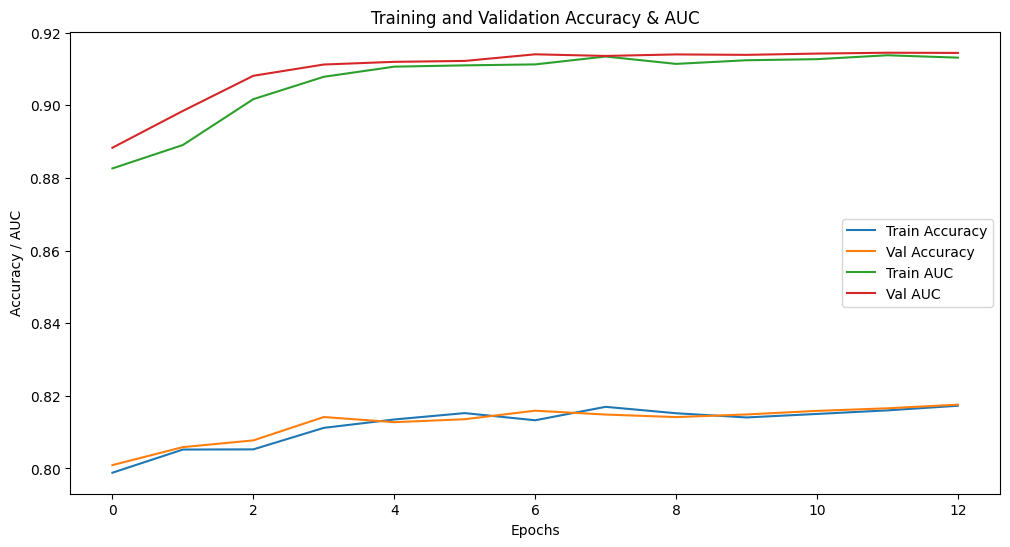

In [17]:
# 10. Графики обучения
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training and Validation Accuracy & AUC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / AUC')
plt.legend()
plt.show()